# Lightly post-process data and save to a new folder
* All surveys (prefrosh, trait, spring well-being)
  * Remove responses with no participant id ('PID')
* Prefrosh and trait surveys
  * (These have individual-item responses, not just scales, and Qualtrics columns like "Finished" and "Response Date")
  * Remove responses with more than half of answers missing
  * Remove responses where P didn't complete the survey ('Finished' = 0)
  * Add several columns indicating how complete the survey was
  * Rename 'RecordedDate' to 'date' (datetime when the user completed the survey)
  * Remove other Qualtrics bookkeeping columns
* Output written to a new data folder, specified in the configuration below.

A good bit of data is dropped in post-processing, as demonstrated in this figure (the figure is generated at the end of this notebook):
![post_process_effects](plots/post_process_summary.png)

**Author: Everett Wetchler (everett.wetchler@gmail.com)**

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Configuration-and-setup" data-toc-modified-id="Configuration-and-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Configuration and setup</a></span></li><li><span><a href="#Prefrosh-Data" data-toc-modified-id="Prefrosh-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prefrosh Data</a></span></li><li><span><a href="#Trait-Data" data-toc-modified-id="Trait-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Trait Data</a></span></li><li><span><a href="#Well-being-Data" data-toc-modified-id="Well-being-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Well-being Data</a></span></li><li><span><a href="#Show-dropped-record-counts-per-dataset" data-toc-modified-id="Show-dropped-record-counts-per-dataset-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Show dropped-record counts per dataset</a></span></li></ul></div>

<div style="background-color: rgba(164,0,0,1);height: 20px"></div><!-- Thick deep-red bar -->

## Configuration and setup

In [1]:
WRITE_POSTPROCESSED = True
DATA_INPUT_DIR = 'data/dropbox/'
DATA_OUTPUT_DIR = 'data/postprocessed/'

In [2]:
####################################################
# Boilerplate import/setup code for general analysis
# everett.wetchler@gmail.com
####################################################

# Plot directly in notebook
# NOTE: break this command into it's own cell, and run
# it BEFORE everything below it. Unfortunately that's
# the only way to get the plot settings to stick.
%matplotlib inline

Everett Wetchler 2019-12-03 20:13:38 PST 

CPython 3.6.5
IPython 7.8.0

numpy 1.17.3
pandas 0.25.1
matplotlib 3.1.0
seaborn 0.9.0
watermark 2.0.1


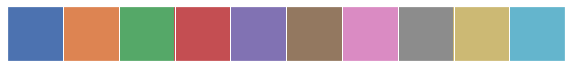

In [3]:
import datetime as dt
import os
import random
import simplejson as json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
sns.set()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

# Customize default chart graphics
mpl.rcParams.update({
  'font.size': 14,
  'axes.titlesize': 'x-large',
  'axes.labelsize': 'large',
  'xtick.labelsize': 'medium',
  'ytick.labelsize': 'medium',
  'legend.fancybox': True,
  'legend.fontsize': 'medium',
  'legend.frameon': True,
  'legend.framealpha': 0.7,
  'figure.figsize': ['9', '6'],
})

# It's useful to have some named colors handy
(SNS_BLUE, SNS_ORANGE, SNS_GREEN,
 SNS_RED, SNS_PURPLE, SNS_BROWN,
 SNS_PINK, SNS_GRAY, SNS_YELLOW,
 SNS_CYAN) = sns.color_palette()
sns.palplot(sns.color_palette())

# Watermark extension to print version/system information
# Flags:
# -a [author] --v (python/ipython versions) -d (date)
# -t (time) -z (timezone) -r (repo)
# -g (git hash) -w (watermark version)
# -p [packages] (package info)
%load_ext watermark
%watermark -a 'Everett Wetchler' -v -d -t -z -w -p numpy,pandas,matplotlib,seaborn

####################################################
# END Boilerplate
####################################################

In [4]:
if not os.path.exists(DATA_OUTPUT_DIR):
    print("Making an empty directory for postproccessed data:", DATA_OUTPUT_DIR)
    os.mkdir(DATA_OUTPUT_DIR)

In [5]:
def load_basic_clean(filename):
    df = pd.read_csv(filename, index_col=0)
    print("%d rows x %d columns" % df.shape)
    
    dates = 0
    for c in df.columns:
        if c.lower().endswith('date'):
            dates += 1
            df[c] = pd.to_datetime(df[c])
    print(f"Converted {dates} columns to datetime")
    
    if 'PID' in df.columns:
        missing_pid = df['PID'].isnull()
        print(f"Dropping {missing_pid.sum()} surveys with no participant id (PID), {len(df)} remain")        
        df = df[-missing_pid]

    return df

In [6]:
def clean_qualtrics(df):
    q_cols = df.loc[:, 'UserLanguage':'PID'].iloc[:, 1:-1]
    N_QUESTIONS = len(q_cols.columns)
    print(f"Found {N_QUESTIONS} survey question columns")
    score_cols = df.loc[:, 'DID':].iloc[:, 1:]
    print(f"Found {len(score_cols.columns)} score columns")

    df['questions_complete'] = q_cols.notnull().sum(axis=1)
    df['questions_incomplete'] = q_cols.isnull().sum(axis=1)
    
    df['scores_complete'] = score_cols.notnull().sum(axis=1)
    df['scores_incomplete'] = score_cols.isnull().sum(axis=1)

    df['time_seconds'] = df['Duration..in.seconds.']
    df['time_minutes'] = df['time_seconds'].apply(lambda s: s // 60)

    df['date'] = df['RecordedDate']
    
    min_incomplete = df['questions_incomplete'].min()
    unfinished = df['Finished'] != 1
    df = df[-unfinished]
    missing_too_many = df['questions_incomplete'] > (N_QUESTIONS / 2)
    df = df[-missing_too_many]
    print(f"Dropping {unfinished.sum()} unfinished surveys, "
          f"plus {missing_too_many.sum()} that skipped > half "
          f"of questions. {len(df)} remain")
    

    dropping = df.loc[:, :'PID'].iloc[:, :-1]
    df = df.loc[:, 'PID':]
    print(f"Dropping {len(dropping.columns)} Qualtrics and individual-question columns, {len(df.columns)} remain")
    
    return df

In [7]:
def dedup(df):
    # De-duplicate
    if 'date' in df.columns:
        df.sort_values('date')
    dedup = df.drop_duplicates(subset='PID')
    dedup.sort_index(inplace=True)
    dups = len(df) - len(dedup)
    if dups > 0:
        print(f"WARNING: {dups} duplicate participant ids (PID) found. Keeping only the latest entry for each PID")      
    else:
        print("No duplicate participant IDs -- all clear.")
    return dedup

In [8]:
def namestr(obj):
    namespace = globals()
    return [name for name in namespace if namespace[name] is obj][0]

In [9]:
def write(df):
    name = namestr(df)
    path = os.path.join(DATA_OUTPUT_DIR, f'{name}.csv')
    if WRITE_POSTPROCESSED:
        print(f"Saving '{name}' data to {path}")
        df.to_csv(path, index=False)
    else:
        print(f"(Not writing '{name}' dataframe yet - "
              f"set WRITE_POSTPROCESSED=True to change this)")

<div style="background-color: rgba(164,0,0,1);height: 20px"></div><!-- Thick deep-red bar -->

## Prefrosh Data

In [10]:
filepath_prefrosh = os.path.join(DATA_INPUT_DIR, 'Survey_Data/Prefrosh_Fall2018/prefrosh_cleaned.csv')
prefrosh = load_basic_clean(filepath_prefrosh)
prefrosh = clean_qualtrics(prefrosh)
prefrosh = dedup(prefrosh)
write(prefrosh)
prefrosh.head()

751 rows x 117 columns
Converted 3 columns to datetime
Dropping 0 surveys with no participant id (PID), 751 remain
Found 83 survey question columns
Found 18 score columns
Dropping 95 unfinished surveys, plus 18 that skipped > half of questions. 638 remain
Dropping 96 Qualtrics and individual-question columns, 28 remain
Saving 'prefrosh' data to data/postprocessed/prefrosh.csv


,PID,NID,DID,Extraversion,BAS,NTB,EC,PD,PT,Prosociality,Loneliness,Loneliness_R,PSS,PSS_R,Subj_Happiness,SWL,MalleableEmpathy,EMPATHY,POSITIVITY,NEGATIVITY,LIFE_SATISFACTION,questions_complete,questions_incomplete,scores_complete,scores_incomplete,time_seconds,time_minutes,date
3,UPl0A7hyV0,NaN,NaN,1.000,1.769231,2.1,3.00,1.50,3.00,3.166667,1.750,2.250,1.00,3.00,4.00,3.8,4.000000,3.291667,1.384615,1.800,3.26250,83,0,18,0,377,6,2018-09-10 16:12:15
4,ra1xsp248Q,NaN,NaN,1.875,2.461538,3.0,3.75,1.25,2.75,3.833333,1.875,2.125,2.50,1.50,2.75,4.4,3.333333,3.416667,2.168269,2.125,2.69375,83,0,18,0,385,6,2018-09-10 16:12:19
5,IqidLJtjxg,11.0,11.0,2.875,2.461538,1.8,3.25,2.00,3.00,3.250000,1.000,3.000,0.25,3.75,5.00,5.2,2.000000,2.875000,2.668269,1.900,4.23750,83,0,18,0,425,7,2018-09-10 16:13:12
6,GR9ggA8Ajc,9.0,9.0,3.375,2.461538,2.4,2.25,1.00,1.75,2.750000,0.750,3.250,1.50,2.50,4.75,6.0,4.333333,2.770833,2.918269,1.700,4.12500,83,0,18,0,449,7,2018-09-10 16:13:52
7,vgxlTMkQs5,7.0,7.0,1.250,1.769231,3.4,3.00,1.25,3.00,2.833333,2.750,1.250,2.50,1.50,1.25,3.0,2.000000,2.708333,1.509615,2.325,1.75000,83,0,18,0,454,7,2018-09-10 16:14:14


<div style="background-color: rgba(164,0,0,1);height: 20px"></div><!-- Thick deep-red bar -->

## Trait Data

In [11]:
filepath_trait = os.path.join(DATA_INPUT_DIR, 'Survey_Data/Trait_Data_2018/Trait_data.csv')
trait = load_basic_clean(filepath_trait)
trait = clean_qualtrics(trait)
trait = dedup(trait)
write(trait)
trait.sample(5)

560 rows x 471 columns
Converted 3 columns to datetime
Dropping 0 surveys with no participant id (PID), 560 remain
Found 404 survey question columns
Found 51 score columns
Dropping 251 unfinished surveys, plus 4 that skipped > half of questions. 305 remain
Dropping 417 Qualtrics and individual-question columns, 61 remain
No duplicate participant IDs -- all clear.
Saving 'trait' data to data/postprocessed/trait.csv


,PID,NID,DID,Extraversion,Agreeableness,Openness,Conscientiousness,NPI,Positive_empathy,Pos_efficacy,Neg_efficacy,Pos_tendency,Neg_Tendency,CESD,STAI_Anxiety,Need_Belong,Prosociality,Loneliness,PSS,SubjHappiness,SWLS,Emp_theory,RS_1,RS_2,Self_Esteem,Self_monitor,Distress_Disclosure,Guidance,Warmth,Integration,Attachment,Nurturance,Reliable,Anticipated_Risks,Anticipated_Benefits,beq.nex,beq.pex,beq.str,PI,SI,CI,BFNE,BAS_drive,BAS_Fun_seeking,BAS_Fun_Reward_responsiveness,Suppression,Cogntive_Reappraisal,Extensic_improve,Extensic_worse,Intrinsic_imrpove,Intrinsic_worse,Empathic_Concern,Perspective_Taking,Personal_Distress,questions_complete,questions_incomplete,scores_complete,scores_incomplete,time_seconds,time_minutes,date
158,D81ScNUgBY,10,10,4.0,5.0,3.0,4.5,4.133333,5.285714,6.50,7.50,6.50,6.75,3.2,3.000000,5.2,3.166667,2.125,1.750000,6.25,5.6,3.500000,4.25,5.875,2.0,19,3.642857,4.0,3.50,3.25,3.5,2.75,4.00,4.75,4.75,4.166667,6.75,7.000000,5.000000,4.25,3.875,5.285714,3.50,3.75,4.6,4.0,5.833333,5.166667,2.333333,4.000000,3.50,3.166667,1.857143,2.285714,399,5,51,0,7359,122,2018-09-30 23:18:44
487,VoAjoLmYnI,8,8,4.0,7.0,7.0,5.5,3.200000,6.000000,6.50,5.75,6.50,3.00,2.6,3.263158,3.2,4.000000,0.250,0.000000,8.25,6.8,6.000000,4.25,5.375,1.0,6,3.428571,4.0,4.00,4.00,4.0,3.00,4.00,2.00,6.00,4.000000,7.25,4.000000,4.333333,2.00,2.500,2.000000,5.00,5.00,5.0,2.0,7.833333,6.000000,2.000000,6.000000,2.00,4.000000,4.000000,0.000000,385,19,51,0,5240,87,2018-09-30 19:37:47
467,uPwqiGUtYL,7,7,4.0,4.5,3.5,6.0,3.733333,5.714286,6.50,6.25,5.50,3.50,3.0,2.789474,3.3,3.000000,0.875,0.750000,7.50,6.8,5.000000,3.00,7.125,2.3,7,3.642857,4.0,3.75,3.75,4.0,3.75,3.75,3.00,4.00,3.833333,6.00,6.500000,5.333333,3.50,5.250,3.285714,4.50,4.50,5.0,4.5,7.666667,5.666667,2.333333,5.666667,2.25,3.000000,2.571429,2.428571,395,9,51,0,12219,203,2018-10-07 20:46:17
435,T3874W4WkA,15,17,6.5,5.5,5.5,7.0,4.066667,5.285714,6.00,7.00,7.00,4.00,3.1,2.263158,NaN,3.500000,0.750,0.666667,6.50,6.0,4.500000,4.75,4.750,1.9,15,NaN,3.5,3.50,3.50,3.0,2.75,3.75,5.75,4.00,NaN,NaN,NaN,NaN,NaN,NaN,4.285714,5.00,5.00,5.0,6.5,6.833333,5.000000,2.000000,5.166667,3.00,3.000000,2.857143,1.285714,306,98,43,8,868129,14468,2018-10-15 15:32:28
54,4sRpiPAQRA,8,8,2.5,3.5,5.0,5.5,4.533333,4.714286,6.25,6.25,6.25,2.50,3.6,3.210526,4.6,2.416667,1.375,2.500000,5.00,6.8,4.833333,5.25,5.500,2.5,13,4.571429,3.0,3.75,3.00,3.0,3.75,3.25,3.00,4.00,3.833333,7.50,3.666667,4.666667,4.50,3.750,5.142857,2.75,4.00,4.4,6.0,4.333333,5.500000,2.666667,4.333333,3.25,2.833333,3.142857,2.000000,395,9,51,0,14752,245,2018-09-30 22:03:06


<div style="background-color: rgba(164,0,0,1);height: 20px"></div><!-- Thick deep-red bar -->

## Well-being Data

In [12]:
filepath_wellbeing_spring = os.path.join(DATA_INPUT_DIR, 'Survey_Data/Wellbeing_Spring_2019/Wellbeing_Spring_2019.csv')
wellbeing_spring = load_basic_clean(filepath_wellbeing_spring)
wellbeing_spring.head()

680 rows x 18 columns
Converted 0 columns to datetime
Dropping 27 surveys with no participant id (PID), 680 remain


,PID,dorm,Wellbeing_self_17,Lonely,Stressed,Satisfied,Rumination,Wellbeing_self_18,Social_Anxiety,Wellbeing_self_22,Anxiety_1,Anxiety_2,Wellbeing_self_19,Depression,Anhedonia,Wellbeing_self_21,Belonging,Wellbeing
3,6jHJKaD4Cb,Alondra,4.0,4.0,0.0,4.0,0.0,4.0,4.0,4.0,2.0,0.0,4.0,4.0,0.0,4.0,4.0,2.714286
4,vcM4I7ahKq,Alondra,2.0,1.0,2.0,2.0,3.0,1.0,0.0,1.0,0.0,1.0,1.0,2.0,2.0,1.0,1.0,1.357143
5,GRS7z5mppv,Alondra,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,4.0,4.0,4.0,4.0,3.785714
6,eaZChV6Zzv,Alondra,4.0,4.0,0.0,3.0,2.0,4.0,4.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,2.928571
7,95dslV1gqt,Alondra,4.0,1.0,1.0,1.0,3.0,2.0,4.0,2.0,2.0,3.0,1.0,2.0,4.0,1.0,1.0,2.214286


In [13]:
N_SCORES = len(wellbeing_spring.columns) - 2
print(N_SCORES, 'total score columns')
wellbeing_spring['scores_missing'] = wellbeing_spring.isnull().sum(axis=1)
wellbeing_spring['scores_missing'].value_counts().sort_index()

16 total score columns


0     546
1       2
10      1
16    104
Name: scores_missing, dtype: int64

In [14]:
wellbeing_spring[wellbeing_spring['scores_missing'] == N_SCORES].head()

,PID,dorm,Wellbeing_self_17,Lonely,Stressed,Satisfied,Rumination,Wellbeing_self_18,Social_Anxiety,Wellbeing_self_22,Anxiety_1,Anxiety_2,Wellbeing_self_19,Depression,Anhedonia,Wellbeing_self_21,Belonging,Wellbeing,scores_missing
36,eaZChV6Zzv,Alondra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
37,DVHOpKeyEt,Alondra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
38,yO9lkWPQCC,Alondra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
39,7WTyBtV0WF,Alondra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
40,jde0LtXmui,Alondra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16


In [15]:
n_blank = (wellbeing_spring['scores_missing'] == N_SCORES).sum()
print(f'Dropping {n_blank} empty records (plus 1 missing more than half of expected scores)')
wellbeing_spring = wellbeing_spring[wellbeing_spring['scores_missing'] == 0]
wellbeing_spring = dedup(wellbeing_spring)
write(wellbeing_spring)

Dropping 104 empty records (plus 1 missing more than half of expected scores)
Saving 'wellbeing_spring' data to data/postprocessed/wellbeing_spring.csv


<div style="background-color: rgba(164,0,0,1);height: 20px"></div><!-- Thick deep-red bar -->

## Show dropped-record counts per dataset

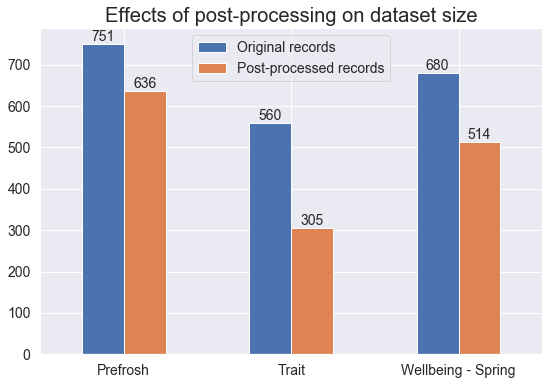

In [16]:
orig_prefrosh = len(pd.read_csv(filepath_prefrosh))
orig_trait = len(pd.read_csv(filepath_trait))
orig_wellbeing_spring = len(pd.read_csv(filepath_wellbeing_spring))
df = pd.DataFrame([
    ['Prefrosh', orig_prefrosh, len(prefrosh)],
    ['Trait', orig_trait, len(trait)],
    ['Wellbeing - Spring', orig_wellbeing_spring, len(wellbeing_spring)],
], columns=['Dataset', 'Original records', 'Post-processed records'])

fig, ax = plt.subplots(1)
df.plot(kind='bar', ax=ax)
ax.set_xticklabels(df['Dataset'], rotation=0)
ax.set_title("Effects of post-processing on dataset size")

# Label values on bars
for i, val in enumerate(df['Original records']):
    ax.text(i-0.125, val, val, horizontalalignment='center', verticalalignment='bottom')
for i, val in enumerate(df['Post-processed records']):
    ax.text(i+0.125, val, val, horizontalalignment='center', verticalalignment='bottom')

fig.savefig('plots/post_process_summary.png')